## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_60.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(39670, 9)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220401]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr_2', 'alpha_kama_5d', 'alpha_AI'],
      dtype='object')

### Rescale AI factor

In [4]:
# need to fix excuteed in privious step
def rescale_AI(data):
    feature = 'alpha_AI'
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                 np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

universe = universe.groupby('trade_date').apply(rescale_AI)

0.03689727957547687


<AxesSubplot:>

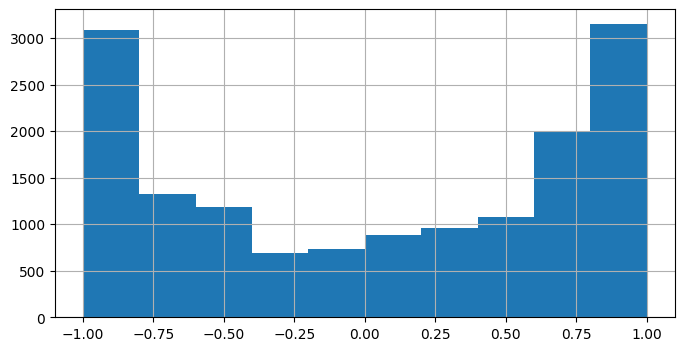

In [5]:
print(universe['alpha_AI'].mean())
universe['alpha_AI'].hist()

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [6]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret  alpha_atr, alpha_010, alpha_AI
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|████████████████████████████████████████| 252/252 [00:01<00:00, 240.81it/s]


### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [7]:
## shif return 5 days
all_factors = universe.copy(deep=True)
all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-2)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date'])
print(universe.shape, all_factors.shape)

(15120, 9) (15120, 10)


In [8]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr_2      0.011278
alpha_kama_5d   -0.045666
alpha_AI        -0.005295
dtype: float64

In [9]:
#all_factors.loc[all_factors['trade_date']>=20220601]

In [10]:
from scipy.stats import zscore
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr_2', 'alpha_kama_5d', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

calendar = all_factors.trade_date.unique() # int64
alpha_df = all_factors[alpha_field + date_and_code]
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 252/252 [00:04<00:00, 58.17it/s]


alpha_atr_2      0.0
alpha_kama_5d    0.0
alpha_AI         0.0
dtype: float64

#### Veiw Factor Returns

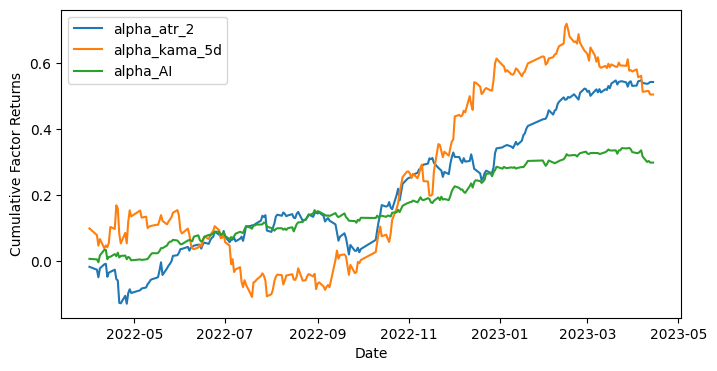

In [11]:
date_list = all_factors.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [12]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=252):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [13]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 1
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    f = rm.factor_returns_
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, f, rm.idiosyncratic_var_vector

# test
start_time = 20220501
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 19
return date 20220505


ts_code,000915.SZ,002322.SZ,002462.SZ,002649.SZ,002728.SZ,002864.SZ,002873.SZ,002923.SZ,002940.SZ,003020.SZ,...,688117.SH,688171.SH,688228.SH,688230.SH,688259.SH,688314.SH,688317.SH,688358.SH,688589.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000915.SZ,0.473267,0.214437,0.195065,0.263152,0.274337,0.273989,0.292117,0.212008,0.201670,0.282170,...,0.193610,0.281080,0.281341,0.318887,0.168357,0.210713,0.347144,0.210079,0.314715,0.184137
002322.SZ,0.214437,0.259831,0.149907,0.202232,0.210827,0.210560,0.224491,0.162927,0.154982,0.216847,...,0.148788,0.216009,0.216209,0.245063,0.129382,0.161932,0.266779,0.161445,0.241857,0.141509
002462.SZ,0.195065,0.149907,0.354810,0.183962,0.191781,0.191538,0.204211,0.148208,0.140981,0.197257,...,0.135347,0.196495,0.196677,0.222924,0.117693,0.147303,0.242678,0.146860,0.220008,0.128725
002649.SZ,0.263152,0.202232,0.183962,0.326281,0.258722,0.258394,0.275490,0.199941,0.190191,0.266109,...,0.182590,0.265081,0.265327,0.300736,0.158774,0.198719,0.327385,0.198121,0.296801,0.173656
002728.SZ,0.274337,0.210827,0.191781,0.258722,0.419139,0.269376,0.287199,0.208439,0.198274,0.277419,...,0.190350,0.276348,0.276604,0.313518,0.165522,0.207165,0.341300,0.206542,0.309416,0.181037


In [14]:
# check estimate risk at spicified time
h=np.array([1]*60) 
(np.dot(h, variance_i).dot(h.T))** 0.5

27.15069712708888

In [15]:
start_time = 20220501
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.mean(axis=0)]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 19
(13980, 3) (13980, 11)


### Combine Factors

In [178]:
#'alpha_atr_2', 'alpha_kama_5d', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code'])
alpha_df['alpha_all'] = 0.05 * alpha_df['alpha_atr_2'] + 0.05*alpha_df['alpha_kama_5d'] + 0.9*alpha_df['alpha_AI']
alpha_df = alpha_df.sort_values(by=['date'])                   
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0 -1.0


### Backtest by Convex Optimization
- use `scipy.optimize.fmin_l_bfgs_b` top optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk rescale weights

In [210]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=5e-3, aversion=0.6): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + aversion * (np.dot(h, variance).dot(h.T)) / 19 \
             #+ Lambda * abs((h-h0)).sum()
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=5e-3, aversion=0.6):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) / 19 \
                #+ Lambda
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220601
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0,100)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal

2347.84919572597 91.95679660633267


<AxesSubplot:>

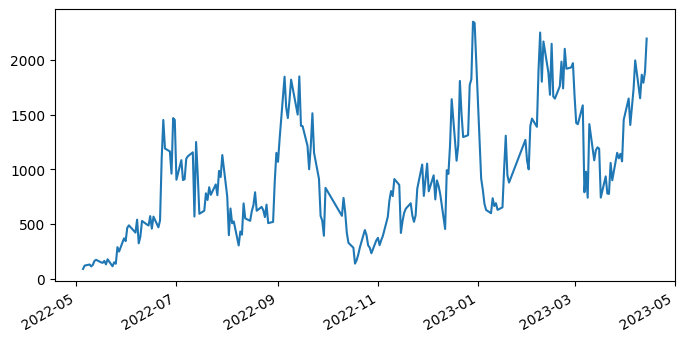

In [211]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [212]:
#for i in positions.keys():
#    positions[i]['h_opt'] = positions[i]['h_opt']/(positions[i]['h_opt'].sum())
#    positions[i]['h_privious'] = positions[i]['h_privious']/(positions[i]['h_privious'].sum())
    #positions[i]['h_opt'] = positions[i]['h_opt']/1500
    #positions[i]['h_privious'] = positions[i]['h_privious']/1500
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [213]:
all_positions = []
for dt in list(positions.keys())[3:]:
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

2347.84919572597 115.66959416955157


2203.865353284509


trade_date  name industry  close   log-ret  alpha_atr_2  \
date       ts_code                                                              
2023-04-14 603508.SH    20230414  思维列控     软件服务  18.89  0.020322     0.778337   
           603368.SH    20230414  柳药集团     医药商业  24.43 -0.010586     0.547034   
           300878.SZ    20230414  维康药业      中成药  25.82 -0.001548     0.609288   
           600750.SH    20230414  江中药业      中成药  21.82 -0.005029     0.607923   
           603538.SH    20230414   美诺华     化学制药  24.30  0.004124     0.741897   
           300378.SZ    20230414  鼎捷软件     软件服务  23.50 -0.016041     0.340119   
           300109.SZ    20230414   新开源     化工原料  25.33  0.001580     0.527792   
           002462.SZ    20230414   嘉事堂     医药商业  15.01  0.008699     1.000000   
           002649.SZ    20230414  博彦科技     软件服务  15.48  0.024854     0.516723   
           002873.SZ    20230414  新天药业      中成药  14.56 -0.004796     0.835128   
           605058.SH    20230414  澳弘电子      元器件  20.96 -0.003810     0.626534   
           605177.SH    20230414  东亚药业     化学制药  24.60  0.003665     0.768126   
           002728.SZ    20230414  特一药业      中成药  22.12  0.003623     0.476857   
           300639.SZ    20230414  凯普生物     医疗保健  17.59 -0.007363     0.981320   
           300739.SZ    20230414  明阳电路      元器件  15.74  0.011502     0.835023   
           688799.SH    20230414  华纳药厂     化学制药  38.26 -0.004433     0.552876   

                      alpha_kama_5d  alpha_AI  residual  alpha_all  \
date       ts_code                                                   
2023-04-14 603508.SH       0.544291  0.936139  0.062651   0.908657   
           603368.SH       0.764138  0.871407  0.103366   0.849825   
           300878.SZ       0.582934  0.882451  0.070653   0.853817   
           600750.SH       0.200294  0.532579  0.169653   0.519732   
           603538.SH       0.628226  0.928022  0.072385   0.903726   
           300378.SZ       0.632677  0.130714  0.067869   0.166282   
           300109.SZ       0.421708  0.910277  0.092961   0.866725   
           002462.SZ       1.000000  1.000000  0.037468   1.000000   
           002649.SZ       0.830687  0.825090  0.182658   0.809951   
           002873.SZ       0.703408  0.739494  0.164394   0.742471   
           605058.SH       0.479625  0.977703  0.063460   0.935241   
           605177.SH       0.855310  1.000000  0.030770   0.981172   
           002728.SZ       0.859316  0.709919  0.133584   0.705735   
           300639.SZ       0.956433  1.000000  0.024351   0.996888   
           300739.SZ       0.801191  0.924051  0.122726   0.913457   
           688799.SH       0.338754  0.885612  0.019046   0.841632   

                      h_privious  h_opt  
date       ts_code                       
2023-04-14 603508.SH    0.000000  100.0  
           603368.SH    0.000000  100.0  
           300878.SZ    0.000000  100.0  
           600750.SH  100.000000  100.0  
           603538.SH    0.000000  100.0  
           300378.SZ  100.000000  100.0  
           300109.SZ    0.000000  100.0  
           002462.SZ   24.558284  100.0  
           002649.SZ  100.000000  100.0  
           002873.SZ  100.000000  100.0  
           605058.SH    0.000000  100.0  
           605177.SH  100.000000  100.0  
           002728.SZ    0.000000  100.0  
           300639.SZ    0.000000  100.0  
           300739.SZ  100.000000  100.0  
           688799.SH  100.000000  100.0

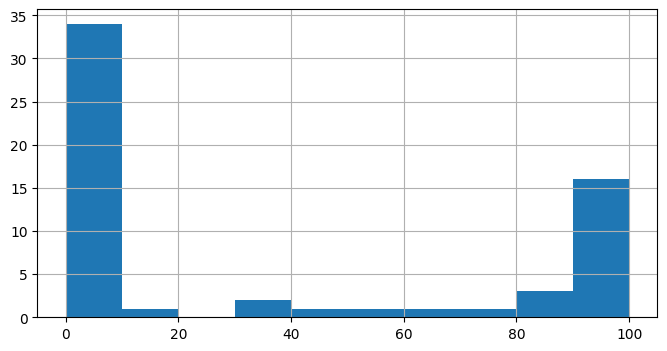

In [209]:
positions[20230414]['h_opt'].hist()
print(positions[20230414].loc[positions[20230414]['h_opt']>0]['h_opt'].sum())
positions[20230414].loc[positions[20230414]['h_opt']==100]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

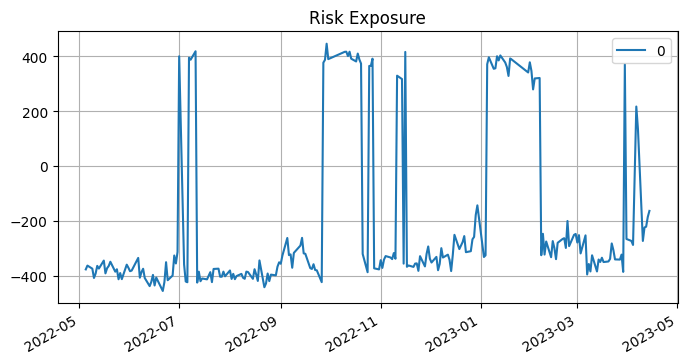

In [194]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

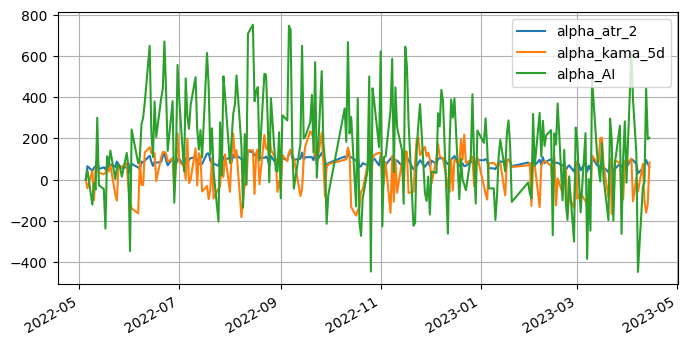

In [197]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code','alpha_atr_2', 'alpha_kama_5d', 'alpha_AI', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0.1, 0.1, 0.8]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_atr_2', 'alpha_kama_5d', 'alpha_AI'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

329.7999999999999


<AxesSubplot:>

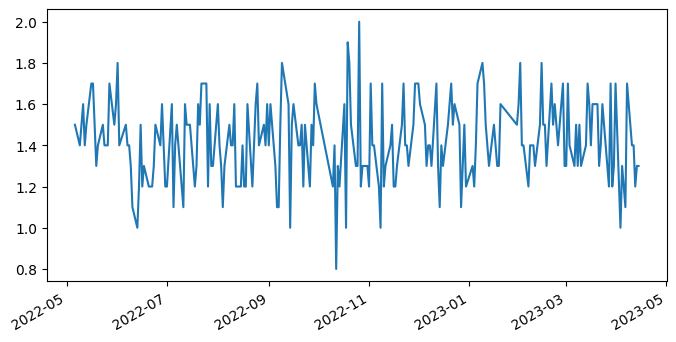

In [199]:
transaction_costs = []
Lambda = 1e-3
for i in range(1,len(h_optimal_list)):
    tmp_change = np.where((h_optimal_list[i] - h_privious_list[i])<0, h_privious_list[i] - h_optimal_list[i], 0)
    #costs = sum(np.dot(tmp_change.values**2, Lambda))
    costs = Lambda * tmp_change.sum()
    transaction_costs.append(costs)
print(sum(transaction_costs))
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Profit-and-Loss (PnL)

2023-04-10 00:00:00


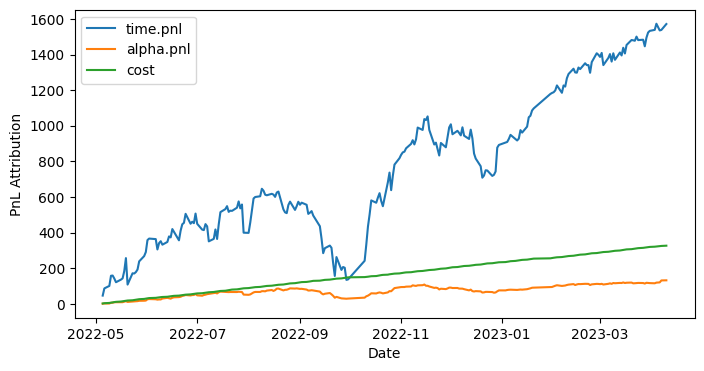

In [200]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()[:-4]
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_atr_2', 'alpha_kama_5d', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"cost"] = transaction_costs[ii]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()